In [1]:
%run ../00_AdvancedPythonConcepts/talktools.py

# sqlite3 interface through Python
UC Berkeley Python class (AY250; 2013-2016)

First, we show simple database creation.

In [2]:
import sqlite3
connection = sqlite3.connect("/tmp/example.db")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE dan_aykroyd (id INTEGER PRIMARY KEY AUTOINCREMENT,
    skit_title TEXT, air_date DATE, season INT, ep INT, role TEXT)"""
cursor.execute(sql_cmd)

Then, we insert some data.

In [3]:
skit_data = [
    ("Trojan Horse Home Security", "10/11/75", 1, 1, "Kenny Vorstrather"), 
    ("E. Buzz Miller's Animal Kingdom", "2/25/78", 3, 12, "E. Buzz Miller"), 
    ("The Coneheads at Home", "10/21/78", 4, 3, "Beldar Conehead")]
for role in skit_data:
    sql_cmd = ("INSERT INTO dan_aykroyd (skit_title, air_date, season, " +     
        "ep, role) VALUES " + str(role))
    cursor.execute(sql_cmd)

Lastly, we run a simple query on the database we just made.

In [5]:
sql_cmd = "SELECT * FROM dan_aykroyd WHERE air_date > '10/12/75'"
cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
connection.commit()
connection.close()

(2, "E. Buzz Miller's Animal Kingdom", '2/25/78', 3, 12, 'E. Buzz Miller')
(3, 'The Coneheads at Home', '10/21/78', 4, 3, 'Beldar Conehead')


Create another table, enter data, run simple join on columns using both tables.

In [6]:
connection = sqlite3.connect("/tmp/example.db")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE jane_curtin (id INTEGER PRIMARY KEY AUTOINCREMENT,
    skit_title TEXT, air_date DATE, season INT, ep INT, role TEXT)"""

cursor.execute(sql_cmd)

skit_data = [
    ("Teen Talk", "7/24/76", 1, 23, "Jane"), 
    ("The Snakehandling O'Sheas", "9/25/76", 2, 2, "Jane O'Shea"), 
    ("The Coneheads at Home", "10/21/78", 4, 3, "Prymaat Conehead")]

for role in skit_data:
    sql_cmd = ("INSERT INTO jane_curtin (skit_title, air_date, season, " +     
        "ep, role) VALUES " + str(role))
    cursor.execute(sql_cmd)

    # Our query is to find which skits featured both Dan Aykroyd and Jane Curtin.
sql_cmd = """SELECT dan_aykroyd.skit_title, dan_aykroyd.air_date, 
    dan_aykroyd.season, dan_aykroyd.ep, dan_aykroyd.role, jane_curtin.role
    FROM dan_aykroyd, jane_curtin WHERE 
    dan_aykroyd.skit_title = jane_curtin.skit_title AND 
    dan_aykroyd.air_date = jane_curtin.air_date"""
cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)

('The Coneheads at Home', '10/21/78', 4, 3, 'Beldar Conehead', 'Prymaat Conehead')


We can also run a left join.

In [7]:
sql_cmd = """SELECT dan_aykroyd.skit_title, dan_aykroyd.air_date, 
    dan_aykroyd.season, dan_aykroyd.ep, dan_aykroyd.role, jane_curtin.role
    FROM dan_aykroyd LEFT JOIN jane_curtin ON 
    dan_aykroyd.skit_title = jane_curtin.skit_title AND 
    dan_aykroyd.air_date = jane_curtin.air_date"""
cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
connection.commit()
connection.close()

('Trojan Horse Home Security', '10/11/75', 1, 1, 'Kenny Vorstrather', None)
("E. Buzz Miller's Animal Kingdom", '2/25/78', 3, 12, 'E. Buzz Miller', None)
('The Coneheads at Home', '10/21/78', 4, 3, 'Beldar Conehead', 'Prymaat Conehead')


# Example with Plotting
Emphasis on data retrieval

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

In [66]:
import sqlite3, datetime
from numpy import loadtxt, array

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    

def get_stock_data(stock_symbol):
       
    response = urlopen("http://ichart.finance.yahoo.com/table.csv?s=" + 
        stock_symbol)
    
    data = response.read()
    response.close()
    output = open(stock_symbol + ".txt", "w")
    output.write(data.decode())
    output.close()
    return loadtxt(stock_symbol + ".txt", skiprows=1, delimiter=",", 
                   dtype='|S10, float, float, float, float, float, float')

!curl -k http://ichart.finance.yahoo.com/table.csv?s=TEAM

Example of data file:
<code>
Date,Open,High,Low,Close,Volume,Adj Close
2012-03-02,544.24,546.80,542.52,545.18,15382800,545.18
2012-03-01,548.17,548.21,538.77,544.47,24380200,544.47
2012-02-29,541.56,547.61,535.70,542.44,33973800,542.44
2012-02-28,527.96,535.41,525.85,535.41,21398000,535.41
2012-02-27,521.31,528.50,516.28,525.76,19515700,525.76
2012-02-24,519.67,522.90,518.64,522.41,14824000,522.41
2012-02-23,515.08,517.83,509.50,516.39,20270400,516.39
2012-02-22,513.08,515.49,509.07,513.04,17243800,513.04
2012-02-21,506.88,514.85,504.12,514.85,21580400,514.85
.
.
.
</code>
continues on until 2000-02-01

Here we create a table, download the stock data, and populate the table with the data.

In [85]:
connection = sqlite3.connect(":memory:")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE stocks (id INTEGER PRIMARY KEY AUTOINCREMENT,
    symbol TEXT, day INT, open FLOAT, high FLOAT, low FLOAT, close FLOAT,
    volume FLOAT, adj_close FLOAT)"""
cursor.execute(sql_cmd)

stock_symbols = ["TEAM","TSLA","AAPL","TWTR","ZEN","GOOG"]
ref_date = datetime.date(2000, 1, 1)

for stock_symbol in stock_symbols:
    data = get_stock_data(stock_symbol)
    for row in data:
        
        year = int(row[0].split(b"-")[0])
        month = int(row[0].split(b"-")[1])
        day = int(row[0].split(b"-")[2])
        
        stock_date = datetime.date(year, month, day)
        
        sql_cmd = """INSERT INTO stocks 
                  (symbol, day, open, high, low, close,volume, adj_close)
                  VALUES ('{}',{},{})""".format(stock_symbol,
                             (stock_date - ref_date).days,
                             ",".join([str(x) for x in row.tolist()[1:]]))
        cursor.execute(sql_cmd)
    connection.commit()

We can plot from the table easily, using the query to select out only the data we want to visualize.

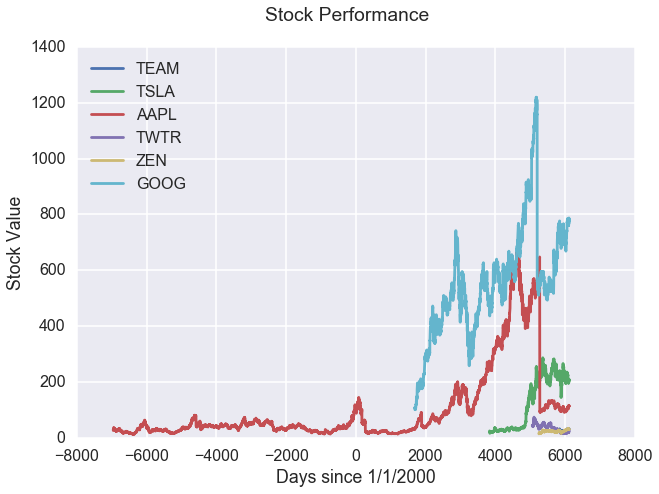

In [86]:
f, ax = plt.subplots(figsize=(10,7))

for ss in stock_symbols:
    sql_cmd = "SELECT day, close FROM stocks WHERE symbol == '" + ss + "'"
    cursor.execute(sql_cmd)
    db_info = array(cursor.fetchall())
    ax.plot(db_info[:, 0], db_info[:, 1], label=ss)

connection.close()

ax.legend(loc=2)
ax.set_xlabel("Days since 1/1/2000")
ax.set_ylabel("Stock Price ($)")
f.suptitle("Stock Performance")